<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/mod_feature_importance_key_insights_from_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔮 Key Insights from XGBoost - Modified Version of Vineet Gupta's Notebook (Public Score: 2.5200 on 2024-11-19)
Original author: Vineet Gupta

Original notebook: https://www.kaggle.com/code/vineetgupta2023/key-insights-from-xgboost-score-2-200/notebook

Many great insights appear in Vineet's notebook!

Added feature engineering in this notebook include:
 1. Rolling statistics (mean and std) for blood glucose values
 2. Lag features for insulin values
 3. Rate of Change features
 4. p_num specific features => look for .groupby('p_num')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from IPython.display import HTML, Image
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print("""
    📊 Blood Glucose Prediction
    ===========================
    🩺 Medical Time Series Analysis
    📈 XGBoost Modeling
    🔬 Feature Engineering

    Loading data...
""")


    📊 Blood Glucose Prediction
    🩺 Medical Time Series Analysis
    📈 XGBoost Modeling
    🔬 Feature Engineering
    
    Loading data...



## Data Loading

In [ ]:
train = pd.read_csv("/kaggle/input/brist1d/train.csv")
test = pd.read_csv("/kaggle/input/brist1d/test.csv")

## Column Groups

In [ ]:
bg_columns = [col for col in train.columns if col.startswith('bg-')]
insulin_columns = [col for col in train.columns if col.startswith('insulin-')]
hr_columns = [col for col in train.columns if col.startswith('hr-')]

## Missing Values Handling

In [ ]:
for df in [train, test]:
    # Forward and backward fill
    df[bg_columns] = df[bg_columns].ffill(axis=1).bfill(axis=1)
    df[insulin_columns] = df[insulin_columns].ffill(axis=1).bfill(axis=1)
    df[hr_columns] = df[hr_columns].ffill(axis=1).bfill(axis=1)

    # Fill remaining missing values with -1
    df.fillna(-1, inplace=True)

# The Work

In [ ]:
def analyze_feature_importance(model, feature_columns):
    """Print feature importance analysis"""
    importances = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    })

    importances = importances.sort_values('importance', ascending=False)
    importances['cumulative'] = importances['importance'].cumsum()
    importances['importance_pct'] = importances['importance'] * 100
    importances['cumulative_pct'] = importances['cumulative'] * 100

    print("\nTop 15 Most Important Features:")
    print(importances.head(15).to_string(index=False))

    # Print feature type analysis
    print("\nFeature Type Analysis:")
    type_analysis = {
        'bg_base': len([x for x in importances.head(15)['feature'] if 'bg-' in x and '_' not in x]),
        'bg_rolling': len([x for x in importances.head(15)['feature'] if 'bg-' in x and 'roll' in x]),
        'bg_rate': len([x for x in importances.head(15)['feature'] if 'bg_rate' in x]),
        'participant': len([x for x in importances.head(15)['feature'] if 'p_' in x]),
    }
    for k, v in type_analysis.items():
        print(f"{k}: {v}")

    return importances

# Modified feature engineering focusing on what worked best
def add_rolling_features_v2(df, columns, windows):
    """Simplified rolling features focusing on means"""
    base_columns = [col for col in columns if
                   not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]

    for col in base_columns:
        for window in windows:
            df[f'{col}_roll_mean_{window}'] = (
                df.groupby('p_num')[col]
                .rolling(window=window, min_periods=1)
                .mean()
                .reset_index(0, drop=True)
            )
    return df

def add_participant_features_v2(df, target_col=None):
    """Simplified participant features focusing on bg metrics"""
    base_bg_cols = [col for col in df.columns if 'bg-' in col and
                    not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]

    # Create MultiIndex columns for agg
    participant_stats = pd.DataFrame()
    for col in base_bg_cols:
        col_stats = df.groupby('p_num')[col].agg(['mean', 'std'])
        col_stats.columns = [f'p_{col}_{stat}' for stat in ['mean', 'std']]
        if participant_stats.empty:
            participant_stats = col_stats
        else:
            participant_stats = participant_stats.join(col_stats)

    participant_stats = participant_stats.reset_index()

    if target_col and target_col in df.columns:
        target_stats = df.groupby('p_num')[target_col].agg(['mean']).reset_index()
        target_stats.columns = ['p_num', 'p_target_mean']
        participant_stats = participant_stats.merge(target_stats, on='p_num', how='left')

    return df.merge(participant_stats, on='p_num', how='left')

def add_rate_of_change_features(df):
    """Calculate rate of change features for key metrics"""
    # Only get the base bg columns (no rolling stat suffixes)
    bg_cols = sorted([col for col in df.columns if 'bg-' in col and
                     not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])],
                    reverse=True)

    for i in range(len(bg_cols)-1):
        col_current = bg_cols[i]
        col_next = bg_cols[i+1]

        # Extract time values
        def extract_minutes(col_name):
            # Extract only the numeric part between 'bg-' and end of string
            time_str = col_name.split('-')[1]
            if ':' in time_str:
                hours, minutes = map(float, time_str.split(':'))
                return hours * 60 + minutes
            else:
                return float(time_str)

        time_current = extract_minutes(col_current)
        time_next = extract_minutes(col_next)

        time_diff = abs(time_next - time_current)

        # Calculate rate of change (per minute)
        if time_diff > 0:  # Prevent division by zero
            df[f'bg_rate_{i}'] = (df[col_current] - df[col_next]) / time_diff
        else:
            df[f'bg_rate_{i}'] = 0

    # Calculate recent trends
    rate_cols = [col for col in df.columns if 'bg_rate_' in col]
    if len(rate_cols) >= 3:
        df['bg_rate_mean_recent'] = df[rate_cols[:3]].mean(axis=1)
        df['bg_rate_std_recent'] = df[rate_cols[:3]].std(axis=1)

    return df

# Activity and participant mapping (keep your existing mapping code here)
activities = pd.DataFrame({'activity': ['Indoor climbing','Run','Strength training','Swim','Bike','Dancing',
                                      'Stairclimber','Spinning','Walking','HIIT','Outdoor Bike','Walk',
                                      'Aerobic Workout','Tennis','Workout','Hike','Zumba','Sport','Yoga',
                                      'Swimming','Weights','Running']})
unique_activities = {activity: i+1 for i, activity in enumerate(activities['activity'].unique())}

participants = pd.DataFrame({'participant': [f'p{str(i).zfill(2)}' for i in range(1, 16)]})
unique_participant = {p: i+1 for i, p in enumerate(participants['participant'].unique())}

# Apply mappings
for df in [train, test]:
    for col in df.columns:
        if 'activity' in col:
            df[col] = df[col].apply(lambda x: unique_activities.get(x, -1) if x != '' else -1)
        if col == 'p_num':
            df[col] = df[col].apply(lambda x: unique_participant.get(x, -1) if x != '' else -1)

# Time feature engineering
for df in [train, test]:
    df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour
    df['minute'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.minute

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

    # Drop original time columns
    df.drop(['hour', 'minute', 'time'], axis=1, inplace=True)

# Enhanced feature engineering
for df in [train, test]:
    # Add participant-specific features
    df = add_participant_features_v2(df, 'bg+1:00' if 'bg+1:00' in df.columns else None)

    # Add rate of change features
    df = add_rate_of_change_features(df)

    # Get base columns for rolling features
    bg_cols = [col for col in df.columns if 'bg-' in col and
               not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]
    insulin_cols = [col for col in df.columns if 'insulin-' in col and
                   not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]
    carbs_cols = [col for col in df.columns if 'carbs-' in col and
                 not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]

    # Using longer windows (12 = 1 hour, 72 = 6 hours, 144 = 12 hours assuming 5-min intervals)
    df = add_rolling_features_v2(df, bg_cols, windows=[12, 72, 144])
    df = add_rolling_features_v2(df, insulin_cols, windows=[12, 72])
    df = add_rolling_features_v2(df, carbs_cols, windows=[12, 72])

# Prepare features
feature_columns = [col for col in train.columns if col not in ['id', 'bg+1:00']]

# Prepare training data
X = train[feature_columns]
y = train['bg+1:00']

# Initialize predictions collection
test_predictions = []
val_scores = []

# Group K-fold cross-validation
gkf = GroupKFold(n_splits=9)

# Train models and make predictions
for train_index, val_index in gkf.split(X, y, groups=train['p_num']):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50,
        verbose=0
    )

    # Analyze feature importance for this fold
    importances = analyze_feature_importance(model, feature_columns)

    val_pred = model.predict(X_val)
    val_scores.append(np.sqrt(mean_squared_error(y_val, val_pred)))

    test_predictions.append(model.predict(test[feature_columns]))

# Calculate final predictions and score
final_predictions = np.mean(np.array(test_predictions), axis=0)
cv_rmse = np.mean(val_scores)

print(f"Cross-validation RMSE: {cv_rmse:.4f}")


Top 15 Most Important Features:
      feature  importance  cumulative  importance_pct  cumulative_pct
      bg-0:00    0.105972    0.105972       10.597228       10.597228
      bg-0:05    0.036319    0.142291        3.631863       14.229092
      bg-0:10    0.016160    0.158451        1.615981       15.845072
      bg-0:15    0.005766    0.164217        0.576635       16.421707
activity-3:40    0.003845    0.168063        0.384549       16.806255
activity-3:45    0.003483    0.171545        0.348280       17.154535
 insulin-0:00    0.003461    0.175006        0.346061       17.500595
activity-5:55    0.003424    0.178430        0.342359       17.842955
      hr-0:00    0.003407    0.181836        0.340665       18.183619
      bg-0:20    0.003366    0.185202        0.336590       18.520208
      bg-0:25    0.003305    0.188507        0.330522       18.850731
     hour_sin    0.003291    0.191798        0.329065       19.179798
activity-3:55    0.003274    0.195072        0.327417    

In [ ]:
### Alternative not used in this notebook version
def add_rolling_features(df, columns, windows):
    """Add rolling window features for specified columns"""
    # Filter out any columns that already have rolling statistics
    base_columns = [col for col in columns if
                   not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]

    for col in base_columns:
        for window in windows:
            df[f'{col}_roll_mean_{window}'] = (
                df.groupby('p_num')[col]
                .rolling(window=window, min_periods=1)
                .mean()
                .reset_index(0, drop=True)
            )
            df[f'{col}_roll_std_{window}'] = (
                df.groupby('p_num')[col]
                .rolling(window=window, min_periods=1)
                .std()
                .reset_index(0, drop=True)
            )
            df[f'{col}_roll_min_{window}'] = (
                df.groupby('p_num')[col]
                .rolling(window=window, min_periods=1)
                .min()
                .reset_index(0, drop=True)
            )
            df[f'{col}_roll_max_{window}'] = (
                df.groupby('p_num')[col]
                .rolling(window=window, min_periods=1)
                .max()
                .reset_index(0, drop=True)
            )
    return df

In [ ]:
## Alternative not used in this version
def add_participant_features(df, target_col=None):
    """Add participant-specific statistical features"""
    # Filter for base columns only
    base_bg_cols = [col for col in df.columns if 'bg-' in col and
                    not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]
    base_insulin_cols = [col for col in df.columns if 'insulin-' in col and
                        not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]
    base_carbs_cols = [col for col in df.columns if 'carbs-' in col and
                      not any(suffix in col for suffix in ['_std', '_mean', '_min', '_max', '_roll'])]

    # Basic statistics per participant
    participant_stats = df.groupby('p_num').agg({
        base_bg_cols[0]: ['mean', 'std', 'min', 'max'],
        base_insulin_cols[0]: ['mean', 'max'],
        base_carbs_cols[0]: ['mean', 'max']
    })

    participant_stats.columns = [f'p_{col[0]}_{col[1]}' for col in participant_stats.columns]
    participant_stats = participant_stats.reset_index()

    # If we have the target column (training only), add target-related stats
    if target_col and target_col in df.columns:
        target_stats = df.groupby('p_num')[target_col].agg(['mean', 'std']).reset_index()
        target_stats.columns = ['p_num', 'p_target_mean', 'p_target_std']
        participant_stats = participant_stats.merge(target_stats, on='p_num', how='left')

    # Merge back to original dataframe
    return df.merge(participant_stats, on='p_num', how='left')

## Final feature importance

In [ ]:
# After the training loop, use the last trained model
print("\nOverall Feature Importance Analysis:")
final_importances = analyze_feature_importance(model, feature_columns)

# Save importances to DataFrame for further analysis if needed
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance statistics:")
print(feature_importance_df.describe())


Overall Feature Importance Analysis:

Top 15 Most Important Features:
      feature  importance  cumulative  importance_pct  cumulative_pct
      bg-0:00    0.110329    0.110329       11.032920       11.032920
      bg-0:05    0.037613    0.147942        3.761268       14.794188
      bg-0:10    0.016562    0.164504        1.656238       16.450428
      bg-0:15    0.006491    0.170996        0.649135       17.099562
      bg-0:20    0.004327    0.175323        0.432711       17.532272
      bg-0:25    0.003893    0.179215        0.389276       17.921549
activity-5:40    0.003844    0.183060        0.384450       18.306000
activity-3:15    0.003749    0.186809        0.374868       18.680868
      hr-0:00    0.003658    0.190466        0.365776       19.046644
activity-4:50    0.003450    0.193917        0.345035       19.391678
     hour_cos    0.003438    0.197354        0.343772       19.735449
 insulin-0:00    0.003256    0.200611        0.325644       20.061094
activity-3:40    0.

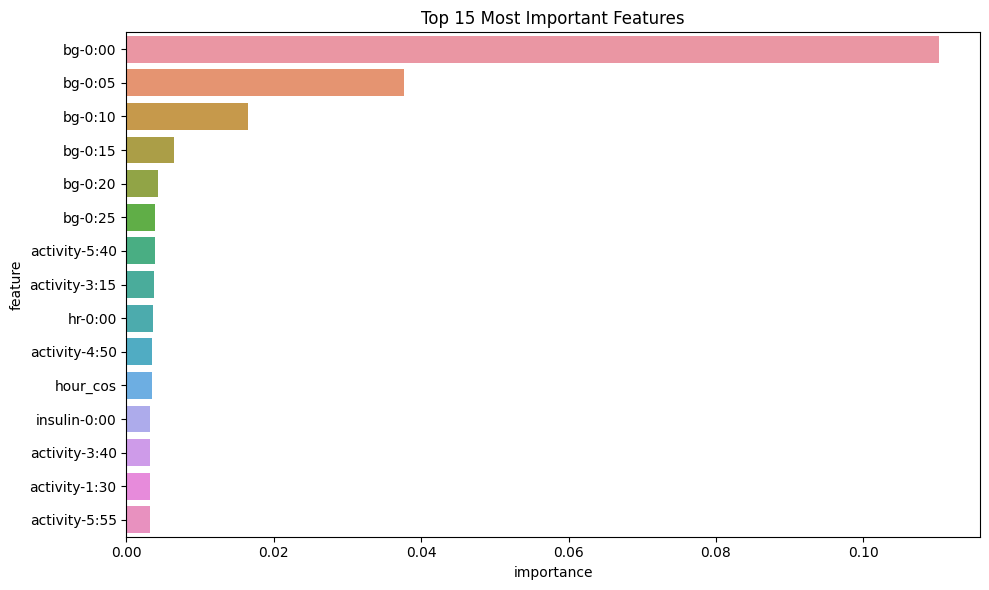

In [ ]:
# Display feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

## The Submission

In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'bg+1:00': final_predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,id,bg+1:00
0,p01_8459,8.658416
1,p01_8460,6.889171
2,p01_8461,7.407545
3,p01_8462,10.181544
4,p01_8463,6.778633
...,...,...
3639,p24_256,6.815250
3640,p24_257,9.951579
3641,p24_258,6.789925
3642,p24_259,8.366776
